# Backtest a Single Model 

The way to gauge the performance of a time-series model is through re-training models with different historic periods and check their forecast within certain steps. This is similar to a time-based style cross-validation. More often, we called it `backtest` in time-series modeling.

The purpose of this notebook is to illustrate how to do 'backtest' on a single model using `TimeSeiresSplitter` and `Backtest`. 

`TimeSeiresSplitter` here is used to make the schem for time-based train-test splits with the data given as well as other required parameters.

`Backtest` is the engine performs fitting and scoring based on a `TimeSeiresSplitter` object.

Currently, there are two schemes supported for the back-testing engine: expanding window and rolling window.

* expanding window: for each back-testing model training, the train start date is fixed, while the train end date is extended forward.
* rolling window: for each back-testing model training, the training window length is fixed but the window is moving forward.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from orbit.lgt import LGT
from orbit.dlt import DLT
from orbit.backtest.backtest import TimeSeriesSplitter, Backtest
from orbit.utils.metrics import mape, smape, wmape

## Load data

In [3]:
data_path = '../examples/data/iclaims.example.csv'
raw_data = pd.read_csv(data_path, parse_dates=['week'])
data = raw_data.copy()
print(data.shape)
data.head(5)

(443, 5)


,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


## Create a TimeSeriesSplitter

###  Expanding window

In [4]:
min_train_len = 380
forecast_len = 20
incremental_len = 20

In [5]:
ex_splitter = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                 window_type='expanding', date_col='week')

In [6]:
print(ex_splitter)


------------ Fold: (1 / 3)------------
Train start index: 0 Train end index: 379
Test start index: 380 Test end index: 399
Train start date: 2010-01-03 00:00:00 Train end date: 2017-04-09 00:00:00
Test start date: 2017-04-16 00:00:00 Test end date: 2017-08-27 00:00:00

------------ Fold: (2 / 3)------------
Train start index: 0 Train end index: 399
Test start index: 400 Test end index: 419
Train start date: 2010-01-03 00:00:00 Train end date: 2017-08-27 00:00:00
Test start date: 2017-09-03 00:00:00 Test end date: 2018-01-14 00:00:00

------------ Fold: (3 / 3)------------
Train start index: 0 Train end index: 419
Test start index: 420 Test end index: 439
Train start date: 2010-01-03 00:00:00 Train end date: 2018-01-14 00:00:00
Test start date: 2018-01-21 00:00:00 Test end date: 2018-06-03 00:00:00



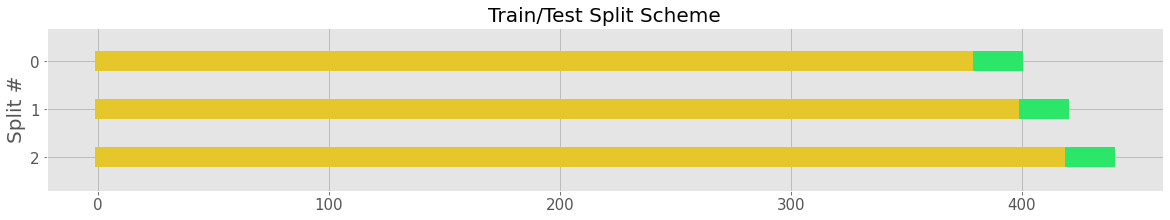

In [7]:
ex_splitter.plot()

### Rolling window

In [8]:
roll_splitter = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                   window_type='rolling', date_col='week')

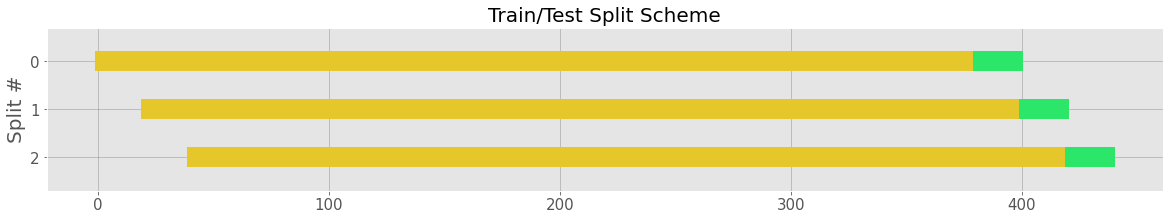

In [9]:
roll_splitter.plot()

### Specifying number of splits

User can also define number of splits using `n_splits` instead of specifying minimum training length.  That way, minimum training length will be automatically calculated.

In [10]:
ex_splitter2 = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                  n_splits=5, window_type='expanding', date_col='week')

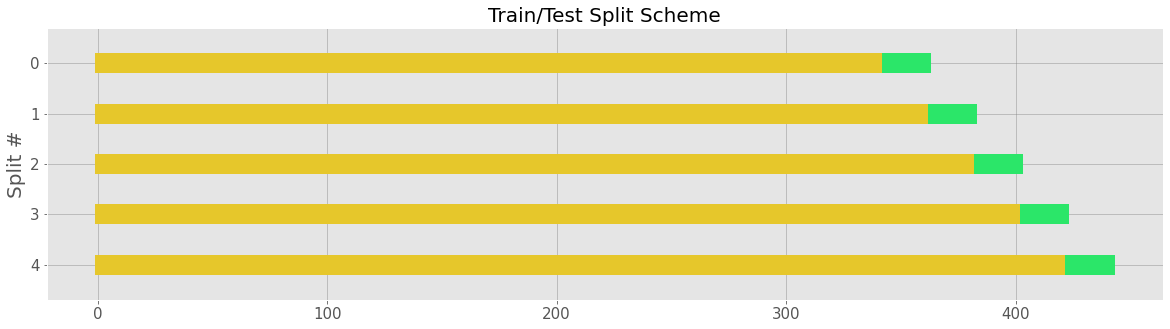

In [11]:
ex_splitter2.plot()

## Backtest

Now, we will use one of the scheme to backtest an `orbit` model.

In [12]:
bt = Backtest(splitter=ex_splitter2)

Instantiate a model that we want to backtest

In [13]:
mod = LGT(
    date_col='week',
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=52,
    seed=8888,
    predict_method='map',
    infer_method='map',
    auto_scale=True,
    is_multiplicative=True
)

Use `fit_score()` to fit the model and computed the desired metrics

In [14]:
bt.fit_score(model=mod, 
             response_col='claims', 
             predicted_col='prediction', 
             metrics={"smape": smape, "mape": mape},
             insample_predict=True,
             save_model=True)

Retrieve the (out-of-sample) predictions for each split

In [15]:
bt.get_predictions().head(5)

,steps,week,claims,trend.unemploy,trend.filling,trend.job,prediction,train_end,split_key
0,1,2016-07-31,219202,1.183973,0.966504,1.013595,282614.179775,2016-07-24,0
1,2,2016-08-07,231542,1.125745,0.909651,0.966451,341495.843163,2016-07-24,0
2,3,2016-08-14,219570,1.145154,0.966504,0.942879,301532.945994,2016-07-24,0
3,4,2016-08-21,217011,1.125745,0.947553,1.013595,264228.563246,2016-07-24,0
4,5,2016-08-28,215688,1.106335,0.928602,0.990023,275811.189371,2016-07-24,0


Retrive insample predictions for each split, only works when `insample_predict=True`

In [16]:
bt.get_insample_predictions().head(5)

,steps,week,claims,trend.unemploy,trend.filling,trend.job,prediction,train_end,split_key
0,1,2010-01-03,651215,1.183973,0.720140,1.119669,651215.000007,2016-07-24,0
1,2,2010-01-10,825891,1.183973,0.814896,1.178599,599550.968850,2016-07-24,0
2,3,2010-01-17,659173,1.203382,0.739091,1.119669,630312.276489,2016-07-24,0
3,4,2010-01-24,507651,1.164564,0.814896,1.107883,489722.586517,2016-07-24,0
4,5,2010-01-31,538617,1.086926,0.776993,1.072525,482010.122448,2016-07-24,0


Retrieve (out-of-sample) scores.

In [17]:
bt.get_scores()

,smape,mape,n_splits
0,0.260218,453.395937,5


Retrieve insample score, only works when `insample_predict=True`

In [18]:
bt.get_insample_scores()

,smape,mape,n_splits
0,0.14542,313.185319,5


When `save_model=True`, one can retrive the fitted models in each backtesting iteration, indexed by the split_key

In [19]:
bt.get_fitted_models()

{0: <orbit.lgt.LGT at 0x13a405f90>,
 1: <orbit.lgt.LGT at 0x13a416a50>,
 2: <orbit.lgt.LGT at 0x13a3b3310>,
 3: <orbit.lgt.LGT at 0x13a3b30d0>,
 4: <orbit.lgt.LGT at 0x13a3d7cd0>}

In [20]:
bt._score_df

,df_key,smape,mape,n_splits
0,test,0.260218,453.395937,5
1,train,0.145420,313.185319,5
